# For time dependent parameters, van der pol etc.

In [1]:
from sympy import symbols, Matrix,re
import numpy as np
import matplotlib
import imageio.v2 as imageio
from IPython.display import Image
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sm
from sympy import symbols, Matrix
import os
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
plt.rcParams['figure.figsize'] = [12, 12]

#Selkov model for glycolysis
def SelkovX(x,y,b,a = 0.1):
    return -x + a*y + x**2*y

def SelkovY(x,y,b,a = 0.1):
    return b - a*y - x**2*y


#Supercritical hopf bifurcation
def x_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*x-w*y #normalformen for superkritiske hopf.
def y_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*y+w*x

#Solutions to the supercritcal hopf bifurcation
def solution_supercrit_Pol(t,mu,w,r0): #Polar coordinates
    C = (r0**2-mu)/(r0**2)
    T = 2*mu*t
    return (mu/(1-C*np.exp(-T)))**0.5

def solution_supercrit_Cart(t, mu,w, x0, y0): #Cartesian coordinates
    return np.cos(w*t)*solution_supercrit_Pol(t, mu, w, x0), np.sin(w*t)*solution_supercrit_Pol(t, mu, w, y0) #x(t) and y(t)


#Van Der Pol

def VanX(x,y,mu,w):
    return y
def VanY(x,y,mu,w):
    return mu*(1-x**2)*y-x

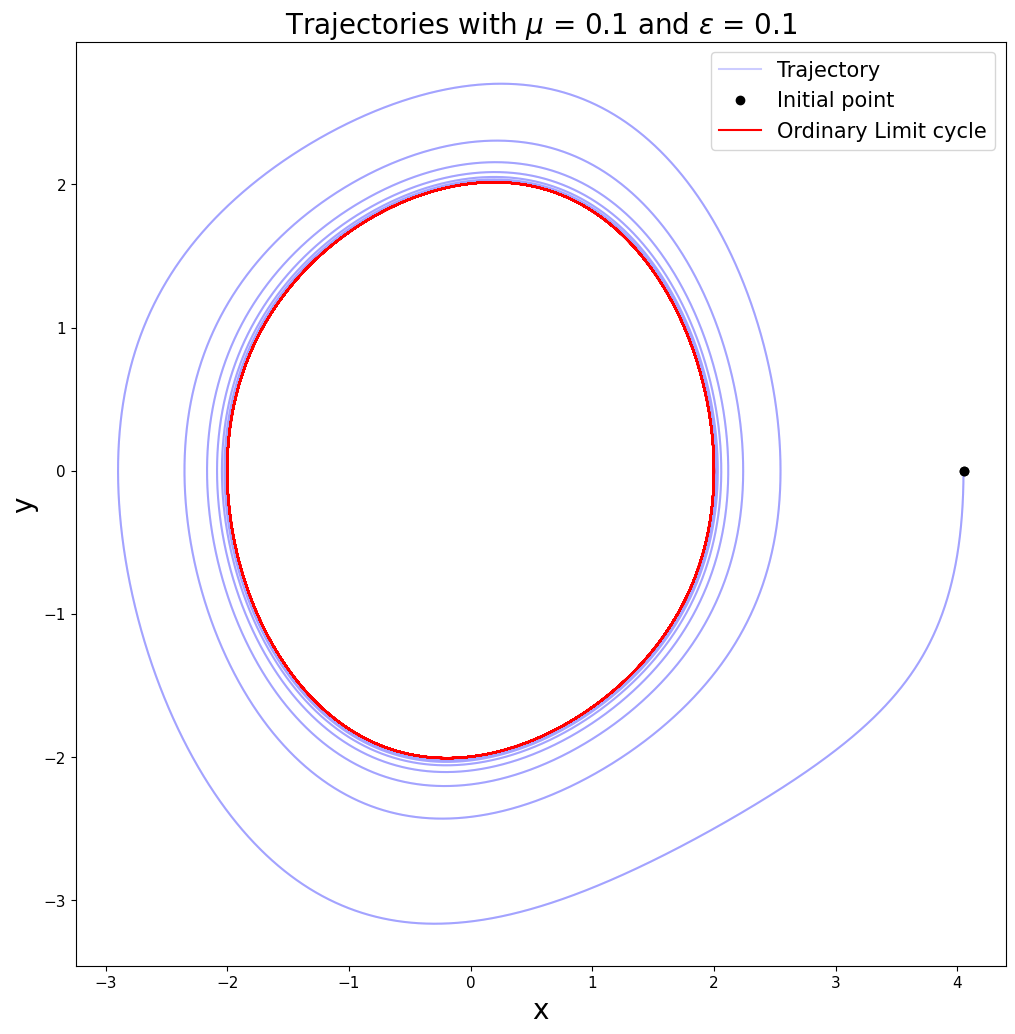

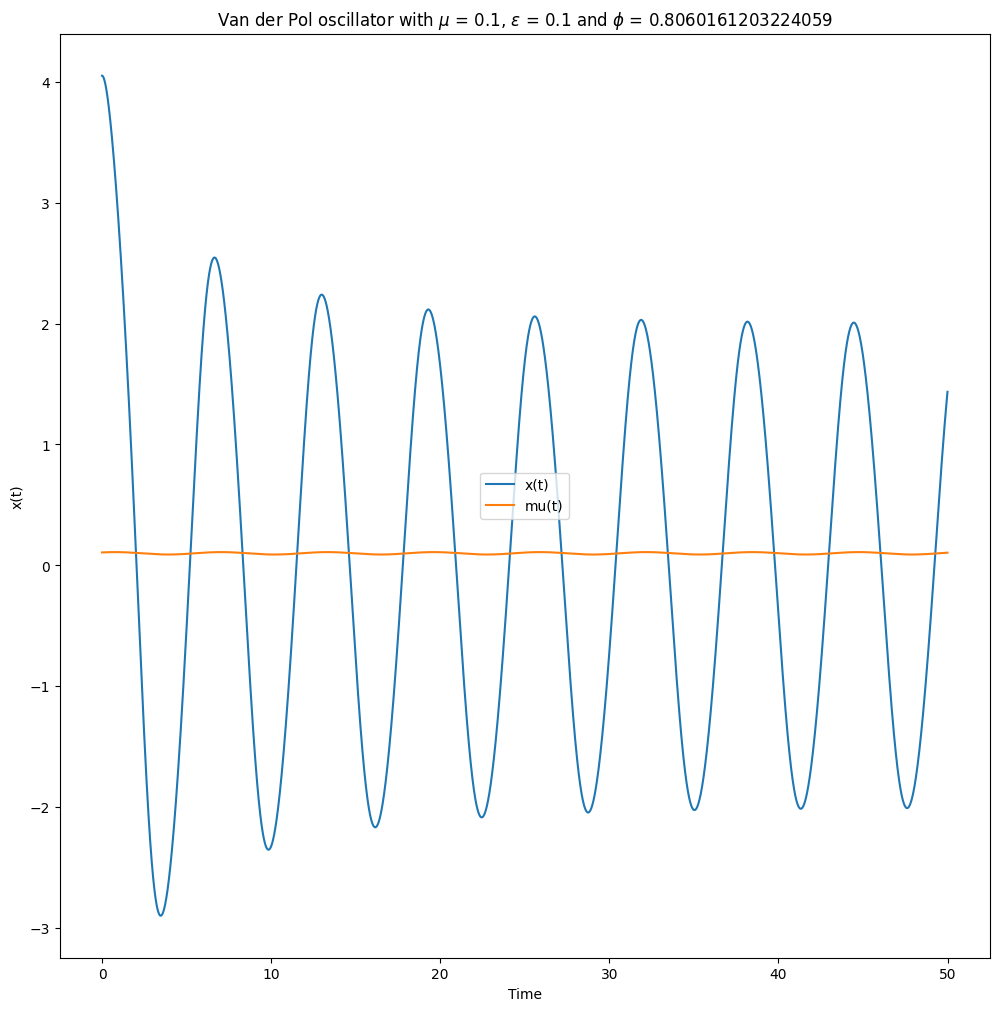

In [14]:
def intgrator_rk4(func_x,func_y,dt,x,y,paramsx,paramsy, D = 0): #Input function, timestep, coordinates and finally params as [...,...,...]
    
    k1x = func_x(x,y,*paramsx)*dt 
    k1y = func_y(x,y,*paramsy)*dt 

    k2x = func_x(x+0.5*k1x, y+0.5*k1y, *paramsx)*dt 
    k2y = func_y(x+0.5*k1x, y+0.5*k1y, *paramsy)*dt 
    
    k3x = func_x(x+0.5*k2x, y+0.5*k2y, *paramsx)*dt 
    k3y = func_y(x+0.5*k2x, y+0.5*k2y, *paramsy)*dt 
    
    k4x = func_x(x+k3x,y+k3y, *paramsx)*dt 
    k4y = func_y(x+k3x,y+k3y, *paramsy)*dt 
    
    xnew = x + 1./6*(k1x+2*k2x+2*k3x+k4x) 
    ynew = y + 1./6*(k1y+2*k2y+2*k3y+k4y) 
    return xnew, ynew

def supercrit_floquet(mu):
    return 2*mu #Floquet at LC

def VDP_floquet(mu,t = '1',eps = 0, phase = 0):
    return mu*(1+eps*np.sin(t+phase))
def LC_coords(xmap,ymap,functionx,functiony,params,runtime,converging_time,dt,dt_conv, eps = 0, phase = 0):
        time_converg = 0
        time_data = 0
        mu,w = params
        running = True
        listsize = int(runtime / dt)
        limitx = np.zeros(listsize*5)
        limity = np.zeros(listsize*5)
        index = 0
        dtr = dt_conv
        t = 0
        #muprime = mu*(1+eps*np.cos(w*t+phase))
        while running:
            muprime = mu*(1+eps*np.sin(w*t+phase))
            xmap, ymap = intgrator_rk4(functionx, functiony, dtr, xmap, ymap, [muprime,w], [muprime,w])
            t += dtr

            if time_converg < converging_time:
                time_converg += dtr
            else:
                dtr = dt
                #t += dt
                time_data += dtr
                limitx[index] = xmap
                limity[index] = ymap
                index +=1
                if time_data > runtime:
                    running = False
        limitx,limity = np.array(limitx),np.array(limity)
        return limitx[:index],limity[:index]

def eig_trajectory(point_amount,solution,functionx,functiony,params, lb = 1.01, ub = 1.0,eps = 0,phase = 0,plot = True,npoints = 50000, dt = 0.005): #Bevægelsesfunktionen
    #The function creates a list for the kdtree, takes some points evenly spaced a distance from the limit cycle, and then calculates the distance to the limit cycle for each trajectory
    Tlist = np.linspace(0,10*np.pi,npoints)
    traject_list = []
    mu = params[0]
    w = params[1]
    spacing_value = np.linspace(lb, ub, point_amount)
    if functionx == x_supercrit:
        limitx, limity = solution(Tlist,mu,1,np.sqrt(mu),np.sqrt(mu)) #Circle of points
        startlist = [(0, spacing * np.sqrt(abs(mu))) for spacing in spacing_value]
    elif functionx == VanX:
        limitx, limity = LC_coords(4,0,VanX,VanY,[mu,w],runtime=200,converging_time=100,dt_conv=dt,dt=dt,eps = eps, phase = phase)
        startlist = [(spacing,0) for spacing in spacing_value]
    if plot:
        fig, ax = plt.subplots()
        for r in startlist:
            x0,y0 = r
            sol_x, sol_y = np.zeros(npoints), np.zeros(npoints)
            sol_x[0], sol_y[0] = x0, y0
            t = 0
            muprime = mu*(1+eps*np.sin(w*t+phase))
            for i in range(1, npoints):
                x0, y0 = intgrator_rk4(functionx, functiony, dt, x0, y0, [muprime,w], [muprime,w])
                sol_x[i], sol_y[i] = x0, y0
                t += dt
                muprime = mu*(1+eps*np.sin(w*t+phase))
            traject_list.append((sol_x,sol_y))
            # Plot the trajectory
            ax.plot(sol_x[0],sol_y[0], 'o', color='black')
            ax.plot(sol_x, sol_y, ls='-', color='blue',alpha = 0.2)
        ax.plot(sol_x, sol_y, ls='-', color='blue', label = "Trajectory", alpha = 0.2)
        ax.plot(startlist[0][0],startlist[0][1], 'o', color = 'black', label = "Initial point")
        ax.set_title(f'Trajectories with $\mu$ = {mu} and $\epsilon$ = {eps}', fontsize = 20)
        ax.plot(limitx, limity, ls='-', color='red',  label = "Ordinary Limit cycle")
        ax.set_xlabel('x', fontsize = 20)
        ax.set_ylabel('y', fontsize = 20)
        plt.xticks(fontsize=11) 
        plt.yticks(fontsize=11)
        plt.legend(fontsize = 15)
        plt.show()
    else:
        for r in startlist:
            x0,y0 = r
            sol_x, sol_y = np.zeros(npoints), np.zeros(npoints)
            sol_x[0], sol_y[0] = x0, y0
            t = 0
            muprime = mu*(1+eps*np.sin(w*t+phase))
            for i in range(1, npoints):
                x0, y0 = intgrator_rk4(functionx, functiony, dt, x0, y0, [muprime,w], [muprime,w])
                sol_x[i], sol_y[i] = x0, y0
                t += dt
                muprime = mu*(1+eps*np.sin(w*t+phase))
            traject_list.append((sol_x,sol_y))
    return traject_list, limitx,limity
def muprim(mu,T, eps =0,phase = 0, freq = 1 ):
    return mu*(1+eps*np.sin(freq*T+phase))

def calculate_distance_to_limit_cycle(trajectory, limit_cycle_x, limit_cycle_y):
    # Create a KDTree for limit cycle points, speeds up instead of using values directly.
    limit_cycle_points = np.vstack((limit_cycle_x, limit_cycle_y)).T
    kdtree = cKDTree(limit_cycle_points)
    
    #distances = []
    trajectory_points = np.vstack((trajectory[0], trajectory[1])).T
    distances, _ = kdtree.query(trajectory_points)
    return distances

def distance_eig(point_amount,solution,functionx,functiony,params,lb = 1.01,ub = 1.05,plot = True, npoints = 50000, dt = 0.005,eps=0,phase=0): #Afstandsberegneren
    #This function calls the eig_trajectory functions, and then calculates the distance to the limit cycle for each trajectory while sorting the floquet exponents and distances
    #Main differenece between distance_trad and the poincaré slice is that the poincare slice is much much faster even with more points (and lower timesteps) while being able to handle way more points.
    traject_list,limx,limy = eig_trajectory(point_amount = point_amount,solution = solution,functionx = functionx,functiony = functiony,params = params, lb=lb,ub=ub,plot = plot, npoints = npoints, dt = dt, eps = eps, phase=phase)

    dist0list = np.array([])
    for sol_x, sol_y in traject_list:
        distances = calculate_distance_to_limit_cycle((sol_x, sol_y), limx, limy)
    for idx,r in enumerate(distances):
        if np.isclose(r,0,atol = 10e-4):
            return idx,traject_list
        
def period_func(x,time):
    peaks, _ = find_peaks(x)
    peak_times = T[peaks]

    periods = np.diff(peak_times)

    average_period = np.mean(periods)
    return average_period
mu = 0.1
w = 1
npoints = 50000
dt = 0.001
epss = 0.1
phs = 0.8060161203224059
trajec0,x,y = eig_trajectory(point_amount=1,solution='none',lb = 4.05,ub = 5,functionx=VanX,functiony=VanY,params = [mu,w],eps = epss,phase = phs,npoints=npoints,dt=dt, plot = True)
T = np.linspace(0,npoints*dt,npoints)
plt.plot(T,trajec0[0][0], label = 'x(t)')
plt.plot(T,muprim(mu,T,eps = epss,phase = phs), label = 'mu(t)')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title(f'Van der Pol oscillator with $\mu$ = {mu}, $\epsilon$ = {epss} and $\phi$ = {phs}')
plt.legend(loc = 'center')
plt.show()


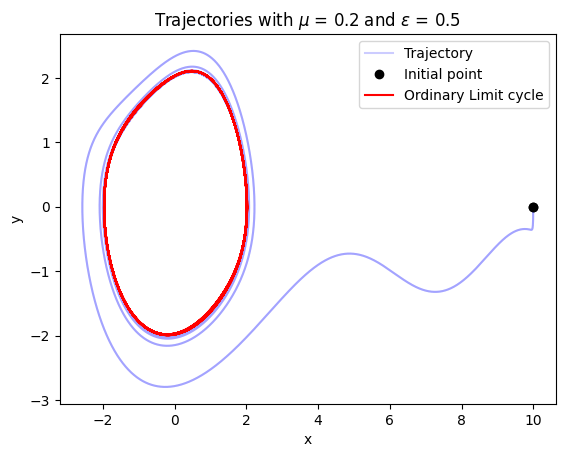

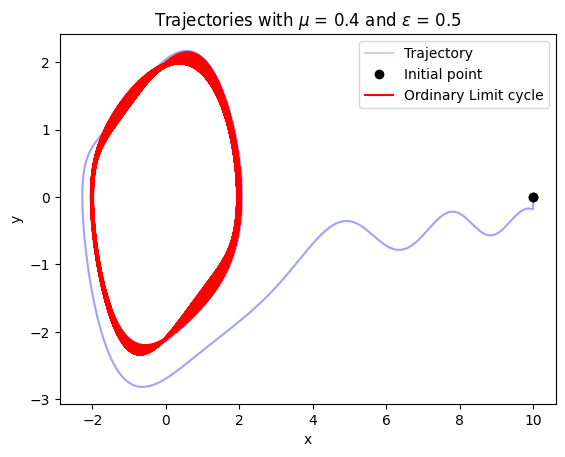

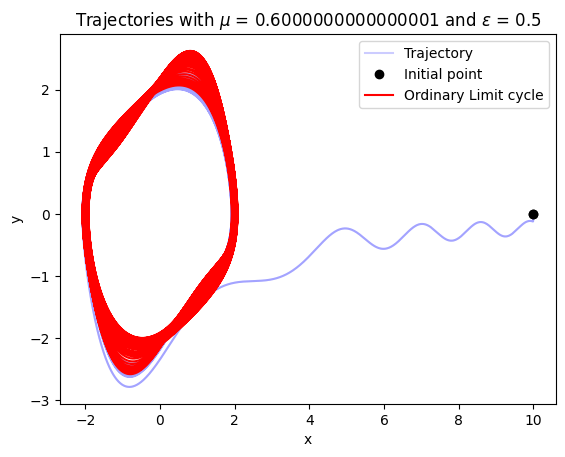

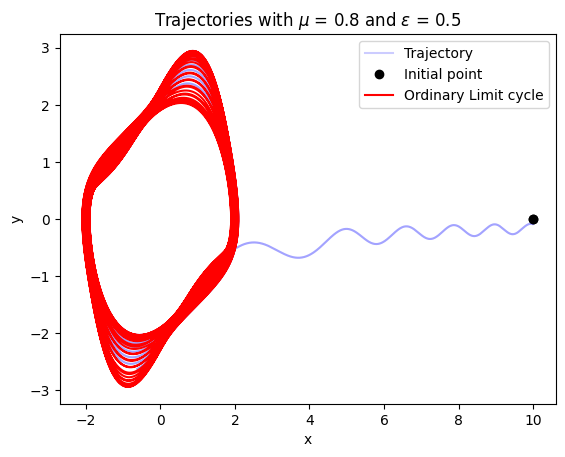

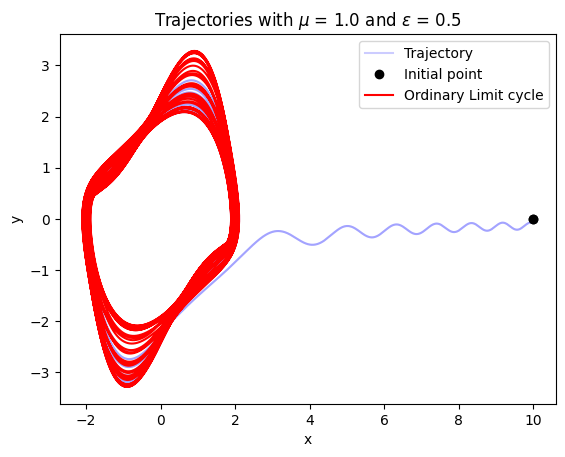

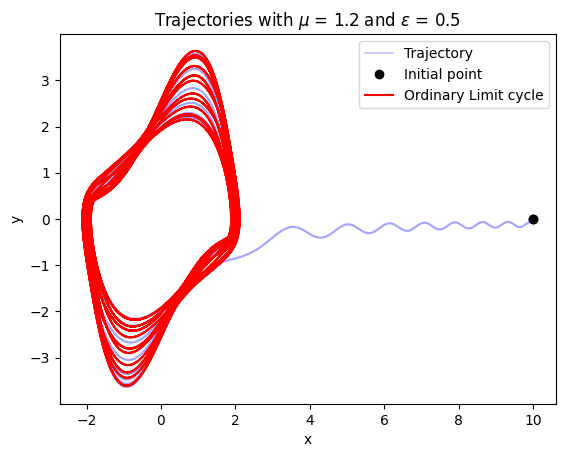

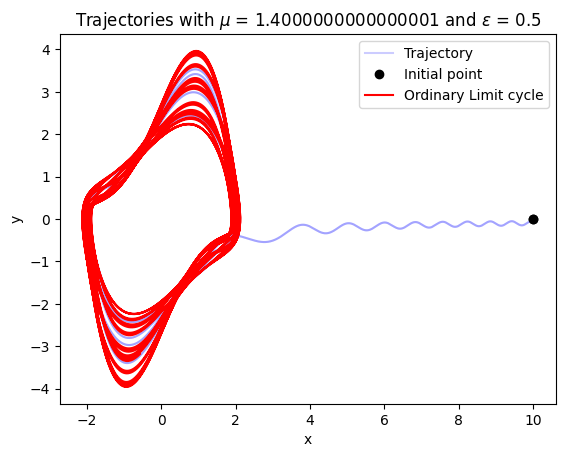

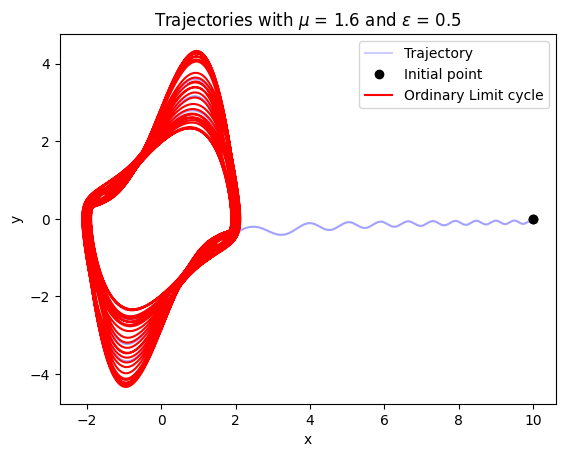

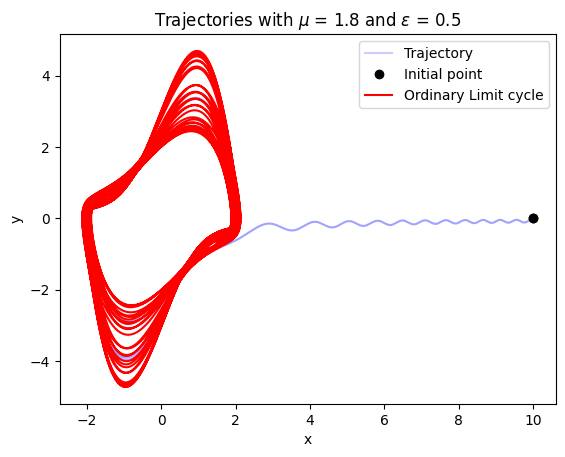

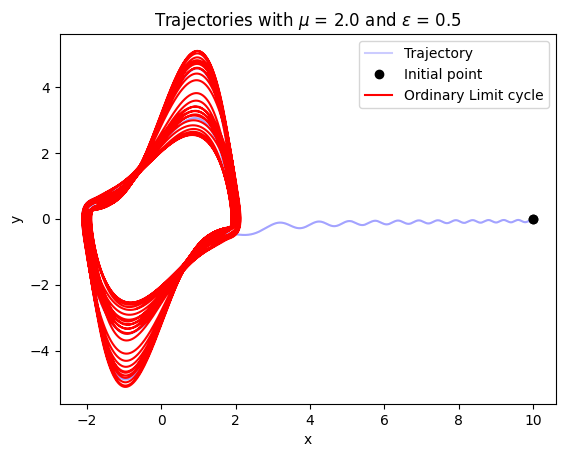

In [93]:
dt = 0.001
epss = 0.5
npoints = 100000
mulist = np.linspace(0.2,2,10)
phs = 0.804849430321941
external_period = np.zeros_like(mulist) #Time before reaching LC
internal_period = np.zeros_like(mulist)
T = np.linspace(0,npoints*dt,npoints)

for j,mu in enumerate(mulist):
    idx,trajec=distance_eig(1,'none',VanX,VanY,[mu,1],lb=10,ub=3,npoints=npoints,dt=dt,eps=epss,phase=phs, plot = True)
    external_period[j] = idx
    #trajec,_,_ = eig_trajectory(point_amount=1,solution='none',lb = 2.5,ub = 5,functionx=VanX,functiony=VanY,params = [mu,w],eps = epss,phase = phs,npoints=npoints,dt=dt, plot = False)
    internal_period[j] = period_func(trajec[0][0][100:],T[:100])



In [ ]:
plt.plot(internal_period,external_period*dt)
plt.ylabel('Time before reaching LC')
plt.xlabel('Period of LC')
plt.axhline(13*np.pi, color = 'red', label = 'Hopf bifurcation')
plt.title(f'Time before reaching LC as a function of LC-Period')

In [ ]:
import numpy as np
from scipy.signal import find_peaks

# Given data: time and x(t)
X= trajec0[0][0]
mupri = muprim(mu,T,epss, phase = 0)# your x(t) array

# 1. Find peaks in x(t) and mu'(t)
peaks_x, _ = find_peaks(X)
peaks_muprime, _ = find_peaks(mupri)

# 2. Match peaks from x(t) to mu'(t) by finding closest peaks
matched_peaks_x = []
matched_peaks_muprime = []

# Loop through peaks in x(t) and find the closest peak in mu'(t)
for peak_x in peaks_x:
    closest_peak_muprime = min(peaks_muprime, key=lambda p: abs(T[p] - T[peak_x]))
    matched_peaks_x.append(peak_x)
    matched_peaks_muprime.append(closest_peak_muprime)

# Convert to numpy arrays
matched_peaks_x = np.array(matched_peaks_x)
matched_peaks_muprime = np.array(matched_peaks_muprime)

# 3. Calculate phase differences for each cycle
phase_differences = T[matched_peaks_x] - T[matched_peaks_muprime]

# 4. Average phase difference over multiple cycles
phi_avg = np.mean(phase_differences)

print(f"Average phase shift: {phi_avg} seconds (or convert to radians)")
